![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src="https://github.com/PracticumAI/practicumai.github.io/blob/84b04be083ca02e5c7e92850f9afd391fc48ae2a/images/icons/practicumai_computer_vision.png?raw=true" alt="Practicum AI: Computer Vision icon" align="right" width=50>
***

# Transfer Learning with Pre-trained Models

In our previous notebooks, we built [CNN models from scratch](01.1_bees_vs_wasps.ipynb) and [explored data augmentation](01.2_data_augmentation.ipynb). While these techniques are valuable, training deep networks from scratch requires significant computational resources and large datasets. 

**Transfer Learning** offers a powerful alternative: we can leverage models that have already been trained on massive datasets and adapt them for our specific task.

## What is Transfer Learning?

Transfer learning involves taking a model that has been pre-trained on a large dataset (like ImageNet with 1.4 million images) and adapting it for a new, related task. The key insight is that the features learned by these models (edges, shapes, textures, objects) are often useful across many different computer vision tasks.

Transfer learning is powerful, but it requires some understanding of how to effectively use pre-trained models. If you finish this notebook and want to learn more, check out *Practicum AI*'s Transfer Learning Intermediate Course. Our GitHub content can be found here: [Transfer Learning](https://github.com/PracticumAI/transfer_learning). Keep an eye out for our certification content on UF's Professional Workforce Development platform as well, found here: [PracticumAI Intermediate Series](https://pwd.aa.ufl.edu/ai/).


## Benefits of Transfer Learning:

1. **Faster Training**: Start with learned features instead of random weights
2. **Better Performance**: Especially with limited data
3. **Less Data Required**: Can achieve good results with smaller datasets
4. **Computational Efficiency**: Don't need to train millions of parameters from scratch

## EfficientNetB5

For this notebook, we'll use **EfficientNetB5**, a state-of-the-art convolutional neural network that achieves excellent accuracy while being computationally efficient. EfficientNetB5:

- Is one of a set of models published by Google engineers [Tan and Le in 2019](https://arxiv.org/abs/1905.11946).
- Was trained on ImageNet (1.4M images, 1000 classes)
- Uses compound scaling to balance network depth, width, and resolution
- Achieves top-1 accuracy of ~83.6% on ImageNet
- Has ~30 million parameters

Let's see how this powerful pre-trained model performs on our bee vs wasp classification task!

## 1. Import the libraries we will use

In [1]:
import sys
!{sys.executable} -m pip install timm

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
            ~~~~~~~~~~~~~~~~~^^^^^^^^^^^
KeyError: '_control_lock'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/home/codespace/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 340, in dispatch_control
    async with self._control_lock:
               ^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/traitlets/traitlets.py", line 687, in __get__
    return t.cast(G, self.get(obj, cls))  # the G should encode the Optional
                     ^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
import random

from torch.utils.data import random_split
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from PIL import Image

# For EfficientNet, we'll use timm (PyTorch Image Models)
import timm

from sklearn.model_selection import train_test_split
import pytorch_lightning as pl

# Many functions are moved to helpers_01.py to keep this file clean.
import helpers_01

# Set seed for reproducibility
pl.seed_everything(42)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


42

## 2. Check PyTorch installation and available models

In [3]:
# Print Pytorch versions and check for GPU
print(f"Pytorch version: {torch.__version__}")
print(f'  Should be "True" if Pytorch was built for GPU: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f"  Available GPU: {torch.cuda.get_device_name()}")
else:
    print("  No GPU available, will use CPU")

# Check if timm is available and show EfficientNet models
try:
    print(f"\nTimm version: {timm.__version__}")
    # List available EfficientNet models (there are a bunch!)
    efficientnet_models = [
        model
        for model in timm.list_models()
        if "efficientnet" in model
    ]
    print(
        f"Available EfficientNetB5 variants: {efficientnet_models}"
    )  
except ImportError:
    print("Timm not available.")
    print(f"Timm installed successfully: {timm.__version__}")

# Set the number of workers for data loading
num_workers = None  # To manually set the number of workers, change this to an integer
num_workers = 0
if num_workers is None:
    # If Slurm is being used, set the number of workers to a Slurm-provided value.
    # If Slurm is not being used, set the number of workers to the number of available CPU cores.
    if os.getenv("SLURM_CPUS_PER_TASK") is not None:
        num_workers = int(os.getenv("SLURM_CPUS_PER_TASK"))
    elif os.getenv("SLURM_NTASKS_PER_NODE") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS_PER_NODE"))
    elif os.getenv("SLURM_NTASKS") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS"))
    else:
        num_workers = os.cpu_count()

print(f"\n\nUsing {num_workers} workers for data loading.")

Pytorch version: 2.10.0+cpu
  Should be "True" if Pytorch was built for GPU: False
  No GPU available, will use CPU

Timm version: 1.0.24
Available EfficientNetB5 variants: ['efficientnet_b0', 'efficientnet_b0_g8_gn', 'efficientnet_b0_g16_evos', 'efficientnet_b0_gn', 'efficientnet_b1', 'efficientnet_b1_pruned', 'efficientnet_b2', 'efficientnet_b2_pruned', 'efficientnet_b3', 'efficientnet_b3_g8_gn', 'efficientnet_b3_gn', 'efficientnet_b3_pruned', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_b8', 'efficientnet_blur_b0', 'efficientnet_cc_b0_4e', 'efficientnet_cc_b0_8e', 'efficientnet_cc_b1_8e', 'efficientnet_el', 'efficientnet_el_pruned', 'efficientnet_em', 'efficientnet_es', 'efficientnet_es_pruned', 'efficientnet_h_b5', 'efficientnet_l2', 'efficientnet_lite0', 'efficientnet_lite1', 'efficientnet_lite2', 'efficientnet_lite3', 'efficientnet_lite4', 'efficientnet_x_b3', 'efficientnet_x_b5', 'efficientnetv2_l', 'efficientnetv2_m', 'efficientnetv2

## 3. Load and prepare the data

We'll use the same bee vs wasp dataset, but this time we need to adjust our data preprocessing to match what EfficientNetB5 expects. Pre-trained models typically expect specific input sizes and normalization.

Found data at: data/bee_vs_wasp_reduced
******************************************************************
Load data with augmentation:
  - Loading the dataset from: data/bee_vs_wasp_reduced.
  - Using a batch size of: 16.
  - Resizing input images to: (224, 224, 3).
  - Train/validation split: 80.0%/20.0%
  - Using 0 workers for data loading
  - Augmentation strength: light
  - Returning class counts for later use? False
******************************************************************

For the full dataset: 
   Class          # of images     # of total
--------------------------------------------
            bee         249         24.7%
   other_insect         254         25.2%
 other_noinsect         252         25.0%
           wasp         252         25.0%
--------------------------------------------
The classes in your dataset are: ['bee', 'other_insect', 'other_noinsect', 'wasp']


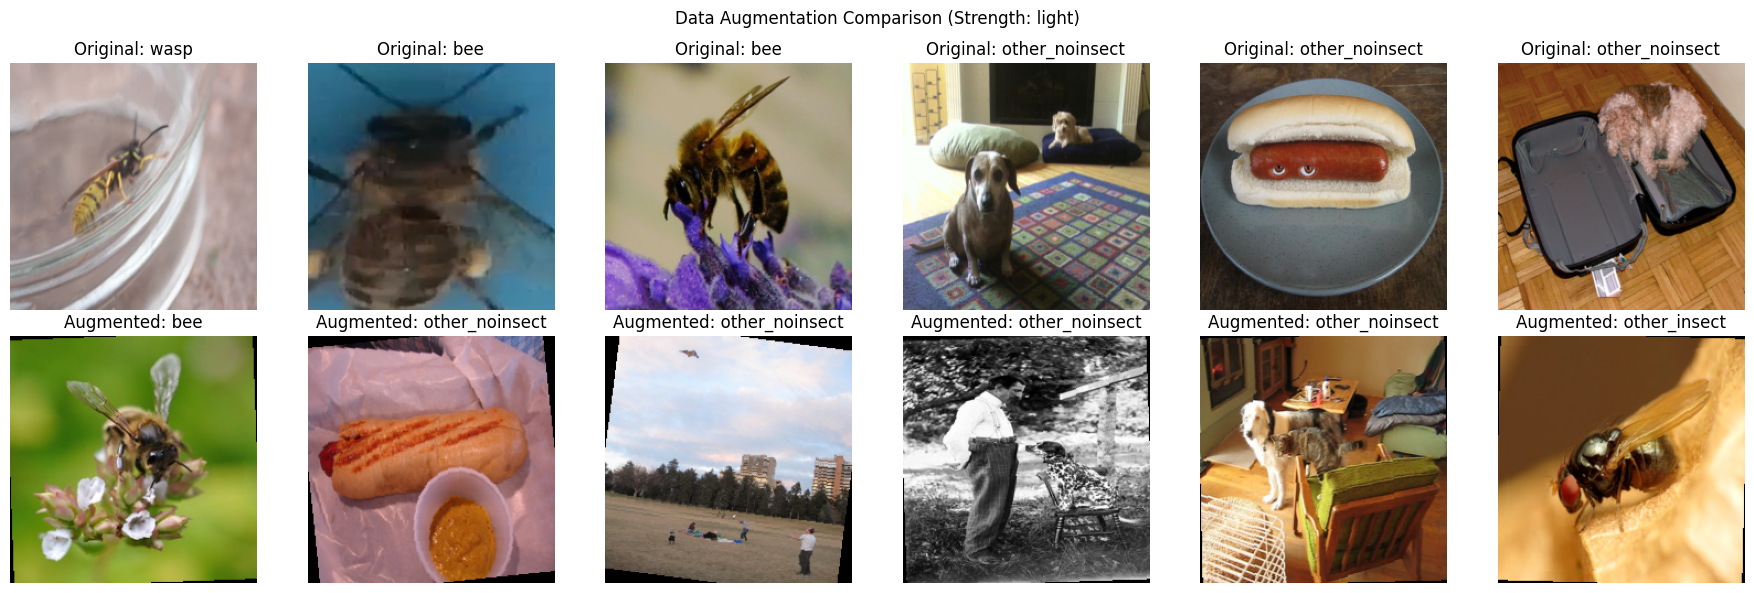

In [4]:
# Get the data path
data_path = helpers_01.manage_data(folder_name="bee_vs_wasp_reduced")


# EfficientNetB5 expects 224x224 images (higher resolution than our previous models)
# This is important for transfer learning - use the same input size as pre-training
data_module = helpers_01.load_display_data_augmented(
    data_path,
    batch_size=16,  # Smaller batch size due to larger images and model
    shape=(224, 224, 3),  # EfficientNetB5 standard input size
    show_pictures=True,
    train_split=0.8,
    num_workers=num_workers,
    augmentation_strength="light",  # Start with light augmentation
)

## 4. Understanding Transfer Learning Approaches

There are several ways to use a pre-trained model:

1. **Feature Extraction**: Freeze the pre-trained layers and only train a new classifier
2. **Fine-tuning**: Allow some or all pre-trained layers to be updated with a small learning rate
3. **Gradual Unfreezing**: Start with frozen layers, then gradually unfreeze more layers

Let's implement these different approaches and compare their performance.

### 4.1 Feature Extraction (Frozen Backbone)

First, let's try feature extraction where we freeze the EfficientNetB5 backbone and only train a new classifier head.

In the output of the cell below, note in particular the number of trainable and non-trainable parameters.

```
1.1 M     Trainable params
28.3 M    Non-trainable params
```

The non-trainable parameters are the frozen parameters of the EfficientNetB5 model. These will not be updated as the model is trained. Only the newly added classifier head, with 1.1 million parameters, will be trained.

We need the new classifier head because EfficientNetB5 is architected to output the probability that an input image belongs to each of the 1,000 categories of the ImageNet dataset. We need it to output the probability that the input is one of our four categories. We can't use the original classifier, because while [bee-eaters](https://en.wikipedia.org/wiki/Bee-eater) (a bird) and bee houses are categories in ImageNet, bees and wasps are not.

TRAINING EFFICIENTNETB5 - FEATURE EXTRACTION (FROZEN BACKBONE)
Backbone (efficientnet_b5) frozen for feature extraction


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


Model created with 29,391,924 total parameters
Trainable parameters: 1,051,140


/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /workspaces/computer_vision/checkpoints exists and is not empty.

  | Name           | Type               | Params | Mode  | FLOPs
----------------------------------------------------------------------
0 | backbone       | EfficientNet       | 28.3 M | train | 0    
1 | global_pool    | AdaptiveAvgPool2d  | 0      | train | 0    
2 | flatten        | Flatten            | 0      | train | 0    
3 | classifier     | Sequential         | 1.1 M  | train | 0    
4 | train_accuracy | MulticlassAccuracy | 0      | train | 0    
5 | val_accuracy   | MulticlassAccuracy | 0      | train | 0    
6 | test_accuracy  | MulticlassAccuracy | 0      | train | 0    
----------------------------------------------------------------------
1.1 M     Trainable params
28.3 M    Non-trainable params
29.4 M    Total params
117.568   Total estimated model params size (MB)
800       Modu

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Epoch 9: 100%|██████████| 51/51 [02:51<00:00,  0.30it/s, v_num=4, train_loss_step=0.155, val_loss=0.278, val_acc=0.916, train_loss_epoch=0.101, train_acc=0.965]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 51/51 [02:51<00:00,  0.30it/s, v_num=4, train_loss_step=0.155, val_loss=0.278, val_acc=0.916, train_loss_epoch=0.101, train_acc=0.965]

Frozen backbone model evaluation:
Testing DataLoader 0: 100%|██████████| 13/13 [00:28<00:00,  0.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9158415794372559
        test_loss           0.2775387763977051
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'train_loss_step', 'epoch', 'val_loss', 'val_acc', 'train_loss_epoch', 'train_acc', 'test_loss', 'test_acc']
Processing tag: hp_metric
Processing tag: train_loss_step
Processing tag: epoch
Process

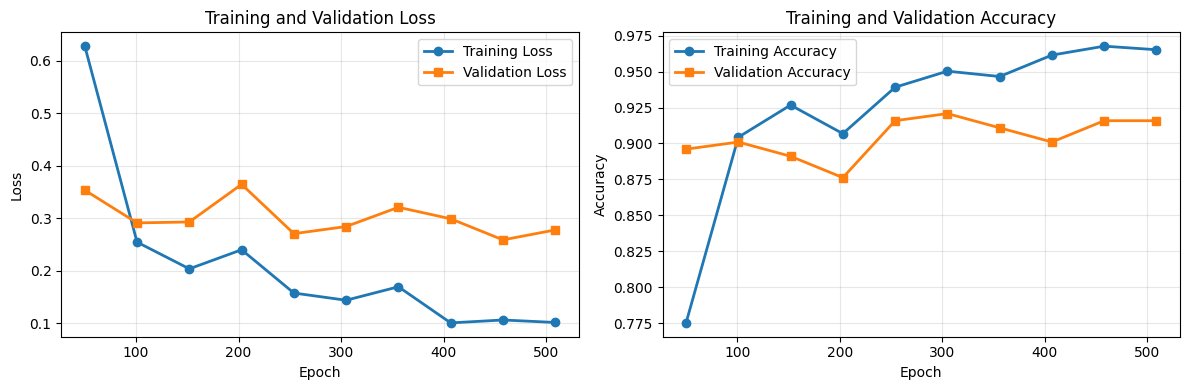

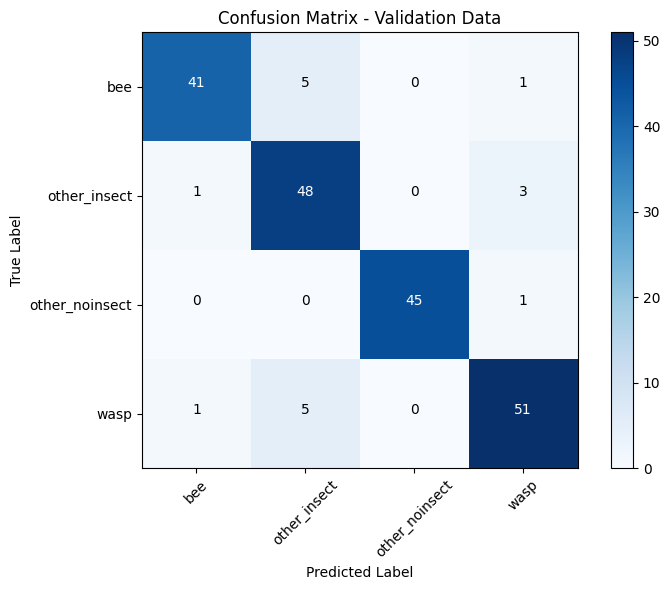


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.953, Recall=0.872, F1=0.911
   other_insect: Precision=0.828, Recall=0.923, F1=0.873
 other_noinsect: Precision=1.000, Recall=0.978, F1=0.989
           wasp: Precision=0.911, Recall=0.895, F1=0.903


In [5]:
# Train EfficientNetB5 with frozen backbone (feature extraction)
print("=" * 60)
print("TRAINING EFFICIENTNETB5 - FEATURE EXTRACTION (FROZEN BACKBONE)")
print("=" * 60)

frozen_model, frozen_trainer = helpers_01.train_transfer_model(
    data_module=data_module,
    num_classes=4,
    learning_rate=0.001,  # Higher learning rate for new classifier head
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    model_name="efficientnet_b5",
    freeze_backbone=True,  # Freeze pre-trained layers
    dropout_rate=0.3,
)

print("\nFrozen backbone model evaluation:")
frozen_results = helpers_01.test_model(data_module, frozen_model, frozen_trainer)

### 4.2 Fine-tuning (Unfrozen Backbone)

Now let's try fine-tuning where we allow the entire model to be updated, but with different learning rates for different parts. Again, pay attention to the number of parameters that are trainable and non-trainable.

In [6]:
# Train EfficientNetB5 with fine-tuning (unfrozen backbone)
print("=" * 60)
print("TRAINING EFFICIENTNETB5 - FINE-TUNING (UNFROZEN BACKBONE)")
print("=" * 60)

finetuned_model, finetuned_trainer = helpers_01.train_transfer_model(
    data_module=data_module,
    num_classes=4,
    learning_rate=0.0001,  # Lower learning rate for fine-tuning
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    model_name="efficientnet_b5",
    freeze_backbone=False,  # Allow all layers to be updated
    dropout_rate=0.3,
)

print("\nFine-tuned model evaluation:")
finetuned_results = helpers_01.test_model(
    data_module, finetuned_model, finetuned_trainer
)

TRAINING EFFICIENTNETB5 - FINE-TUNING (UNFROZEN BACKBONE)
Backbone (efficientnet_b5) unfrozen for fine-tuning
Model created with 29,391,924 total parameters
Trainable parameters: 29,391,924


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /workspaces/computer_vision/checkpoints exists and is not empty.

  | Name           | Type               | Params | Mode  | FLOPs
----------------------------------------------------------------------
0 | backbone       | EfficientNet       | 28.3 M | train | 0    
1 | global_pool    | AdaptiveAvgPool2d  | 0      | train | 0    
2 | flatten        | Flatten            | 0      | train | 0    
3 | classifier     | Sequential         | 1.1 M  | train | 0    
4 | train_accuracy | MulticlassAccuracy | 0      | train | 0    
5 | val_accuracy   | MulticlassAccuracy 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Epoch 0:   0%|          | 0/51 [00:00<?, ?it/s]                            

[rank: 0] Received SIGTERM: 15


: 

## 5. Comparing Transfer Learning vs Training from Scratch

Let's compare our transfer learning results with training from scratch to see the benefits.

In [ ]:
# For comparison, let's also train our simple CNN from scratch with the same data
print("=" * 60)
print("TRAINING SIMPLE CNN FROM SCRATCH (FOR COMPARISON)")
print("=" * 60)

scratch_model, scratch_trainer = helpers_01.train_model(
    data_module=data_module,
    num_classes=4,
    learning_rate=0.001,
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    input_shape=(3, 224, 224),  # Same input size for fair comparison
    dropout_rate=0.5,
    conv_padding=1,
)

print("\nFrom-scratch model evaluation:")
scratch_results = helpers_01.test_model(data_module, scratch_model, scratch_trainer)

## 6. Results Comparison and Analysis

In [ ]:
# Extract test accuracies from each model
models_summary = {
    "EfficientNetB5 (Frozen)": frozen_results[0]["test_acc"],
    "EfficientNetB5 (Fine-tuned)": finetuned_results[0]["test_acc"],
    "Simple CNN (From Scratch)": scratch_results[0]["test_acc"],
}

print("=" * 60)
print("TRANSFER LEARNING RESULTS COMPARISON")
print("=" * 60)
print(f"{'Model':<30} {'Test Accuracy':<15} {'Training Time':<15}")
print("-" * 60)

for model_name, accuracy in models_summary.items():
    print(f"{model_name:<30} {accuracy:<15.3f} {'~10 epochs':<15}")

# Create a bar plot comparing accuracies
plt.figure(figsize=(12, 6))
model_names = list(models_summary.keys())
accuracies = list(models_summary.values())

colors = ["lightblue", "darkblue", "red"]
bars = plt.bar(model_names, accuracies, color=colors)
plt.title("Transfer Learning vs Training from Scratch: Performance Comparison")
plt.ylabel("Test Accuracy")
plt.xlabel("Model Type")
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{acc:.3f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("KEY OBSERVATIONS:")
print("=" * 60)
print("1. Transfer learning typically achieves higher accuracy faster")
print("2. Fine-tuning often outperforms feature extraction")
print("3. Pre-trained models start with meaningful features")
print("4. Training from scratch requires more data and time to converge")
print("5. EfficientNetB5 benefits from ImageNet's diverse feature representations")

## 7. Analyzing What the Model Learned

Let's examine what features the pre-trained EfficientNetB5 model is using for our bee vs wasp classification.

In [ ]:
# Let's visualize some predictions to understand what the model learned
finetuned_model.eval()

# Get a batch of validation images
val_loader = data_module.val_dataloader()
images, labels = next(iter(val_loader))

# Get class names
class_names, _ = data_module.get_class_info()

# Move to same device as model
device = next(finetuned_model.parameters()).device
images = images.to(device)

# Get predictions
with torch.no_grad():
    outputs = finetuned_model(images)
    probabilities = F.softmax(outputs, dim=1)
    predicted_classes = torch.argmax(outputs, dim=1)

# Visualize first 8 predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    # Convert image back to displayable format
    img = images[i].cpu().numpy().transpose(1, 2, 0)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    # Get prediction info
    true_class = class_names[labels[i]]
    pred_class = class_names[predicted_classes[i]]
    confidence = probabilities[i, predicted_classes[i]].item()

    # Determine color based on correctness
    color = "green" if labels[i] == predicted_classes[i] else "red"

    axes[i].imshow(img)
    axes[i].set_title(
        f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}",
        color=color,
        fontweight="bold",
    )
    axes[i].axis("off")

plt.suptitle("EfficientNetB5 Predictions on Validation Data", fontsize=16)
plt.tight_layout()
plt.show()

## 8. Advanced Transfer Learning: Model Comparison

Let's explore how different pre-trained models perform on our task.

In [ ]:
# Compare different pre-trained models
print("=" * 60)
print("COMPARING DIFFERENT PRE-TRAINED MODELS")
print("=" * 60)

# Test with a smaller EfficientNet model for comparison
print("Training EfficientNetB3 (smaller model)...")
efficientb3_model, efficientb3_trainer = helpers_01.train_transfer_model(
    data_module=data_module,
    num_classes=4,
    learning_rate=0.0001,
    max_epochs=5,  # Fewer epochs for demonstration
    accelerator="auto",
    devices="auto",
    model_name="efficientnet_b3",
    freeze_backbone=False,
    dropout_rate=0.3,
)

efficientb3_results = helpers_01.test_model(
    data_module, efficientb3_model, efficientb3_trainer
)

# Compare model sizes and performance
model_comparison = {
    "EfficientNetB3": {
        "accuracy": efficientb3_results[0]["test_acc"],
        "params": "~12M parameters",
        "input_size": "224x224",
    },
    "EfficientNetB5": {
        "accuracy": finetuned_results[0]["test_acc"],
        "params": "~30M parameters",
        "input_size": "224x224",
    },
    "Simple CNN": {
        "accuracy": scratch_results[0]["test_acc"],
        "params": "~100K parameters",
        "input_size": "224x224",
    },
}

print("\nModel Comparison Summary:")
print("-" * 70)
print(f"{'Model':<15} {'Accuracy':<10} {'Parameters':<15} {'Input Size':<12}")
print("-" * 70)

for model_name, info in model_comparison.items():
    print(
        f"{model_name:<15} {info['accuracy']:<10.3f} {info['params']:<15} {info['input_size']:<12}"
    )

## 9. Conclusion and Best Practices

### Key Takeaways from Transfer Learning:

1. **Dramatic Performance Improvement**: Pre-trained models typically achieve much better accuracy than training from scratch, especially with limited data.

2. **Faster Convergence**: Transfer learning models converge much faster since they start with meaningful features.

3. **Resource Efficiency**: Requires fewer computational resources and training time.

4. **Model Size vs Performance**: Larger models (EfficientNetB5) generally perform better than smaller ones (EfficientNetB3), but at the cost of computational requirements.

### Best Practices for Transfer Learning:

#### **Choosing the Right Approach:**
- **Feature Extraction**: When your dataset is small and similar to the pre-training dataset
- **Fine-tuning**: When you have sufficient data and computational resources
- **Gradual Unfreezing**: For very large models or when training resources are limited

#### **Learning Rate Strategy:**
- Use **lower learning rates** (0.0001-0.001) for fine-tuning pre-trained layers
- Use **higher learning rates** (0.001-0.01) for new classifier heads
- Consider **different learning rates** for different parts of the model

#### **Data Preprocessing:**
- **Match the preprocessing** used during pre-training (normalization, input size)
- **Use appropriate input sizes** (224x224 for most ImageNet models)
- **Apply similar augmentations** that were used during pre-training

#### **Model Selection:**
- **EfficientNet**: Great balance of accuracy and efficiency
- **ResNet**: Robust and widely used
- **Vision Transformer (ViT)**: State-of-the-art for many tasks

### When to Use Transfer Learning:

✅ **Ideal for:**
- Small to medium datasets
- Limited computational resources
- Quick prototyping and development
- Computer vision tasks similar to ImageNet

❌ **Consider alternatives when:**
- Very large custom datasets available
- Domain is very different from pre-training data
- Specific architectural requirements

Transfer learning is one of the most powerful techniques in modern deep learning, enabling remarkable performance improvements with relatively little additional effort!

----
## Push changes to GitHub <img src="images/push_to_github.png" alt="Push to GitHub icon" align="right" width=150>

 Remember to **add**, **commit**, and **push** the changes you have made to this notebook to GitHub to keep your repository in sync.

In Jupyter, those are done in the git tab on the left. In Google Colab, use File > Save a copy in GitHub.